In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

$\newcommand{\normalN}{\mathcal{N}}$

# Introduction

The working example we will use in this notebook is describing the orientation tuning of a neuron. To do this, we might perform an experiment where a monochrome grating is shown to the animal while the recording from the neuron of interest. Repeating the experiment with different grating orientations, we would obtain the firing rate $f$ of this neuron as a function of the orientation $θ$.

<img src='./orientation-tuning_plot.png' style='width: 50%'/>

Clearly this neuron responds preferentially to grating orientations around 90°, and with about twice the firing rate as the least preferential direction. The latter is an estimation on the *contrast ratio*, which is the specific quantity we want to evaluate. But to do so with any scientific credibility, we need to do a proper data analysis that takes into account the observation noise – “eyeballing” the number just won't cut it.

*Remark* – Contrast is a measure of the amount of *signal* in an output.

# Loading and plotting the data

This first step to any data analysis is to grab the data. We've provided the data for the plot above in the file `orientation-tuning_data.npz`. It comprises two Numpy arrays:

* `θarr`: the array of orientations
* `farr`: the array of corresponding measured firing rates

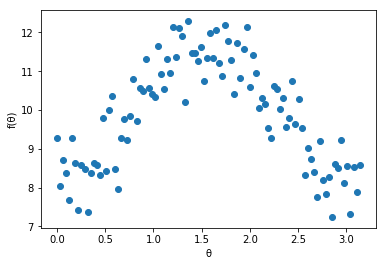

In [2]:
data = np.load("orientation-tuning_data.npz")
θarr = data['θarr']
farr = data['farr']

plt.scatter(θarr, farr)
plt.xlabel("θ")
plt.ylabel("f(θ)")

# Defining a model

## On the ubiquity of models
Any interpretation of data implies an underlying model of how the different variables in that data are related. For example, a typically used measure to show that two variables are related is the *correlation coefficient*, which takes values between -1 and 1 (with 0 corresponding fully uncorrelated variables). However, applying this measure to data implicitly assumes a *linear* relationship between the variables—effectively, computing the correlation is akin to imposing a linear model to data. That is why, despite the plot above clearly showing a relationship between $θ$ and $f(θ)$, the correlation between those two quantities is a minuscule $r = -0.043$:

In [3]:
np.corrcoef(θarr, farr)

array([[ 1.       , -0.0429521],
       [-0.0429521,  1.       ]])

Thankfully, a model doesn't have a be perfect to be useful. In data analysis, the game is not to find the “perfect“ model, but rather a “good enough” model, that explains the data sufficiently well. We can then compute statistics that tell us how well *that* model fits the data.

## Our toy model
When choosing a model, a good principle is to apply Occam's razor: make it as simple as possible, adding only as much complexity as required to explain the feature that interests us.
In this case, we need a model that minimally:

- captures the orientation corresponding to maximum neural response $θ_0$;
- is periodic (rotating the grating by 180° should give the same response);
- ensures $f(θ)$ is always positive.

A possible model with these characteristics would be
$$f(θ) = α \cos( 2(θ - θ_0) ) + β \,,$$

It is important to stress that this only *a* model: plenty of other models would also appropriately explain our data. They may involve different parameters, which would take on different values, but they should all agree on measurable quantities: **fitting any sufficiently expressive model to the same data will produce similar estimates for the contrast and preferred orientation.**

To translate this model into Python, we define a function `f` which returns the firing rate. You should be able to recognize the components of the equation above in the definition below:

In [4]:
def f(θ, α, β, θ0):
    return α * np.cos((θ - θ0)*2) + β

# Determining the contrast ratio

The contrast ratio is given by 
$$c = \frac{f_{max}}{f_{min}} \,.$$
Since $f_{max}$ and $f_{min}$ respectively occur when $θ = θ_0$ and $θ = θ_0 \pm \tfrac{\pi}{4}$, we find that
\begin{equation}
c = \frac{f(θ_0)}{f(θ_0 + \tfrac{\pi}{4})} = \frac{α + β}{-α + β} \,. \tag{1}
\end{equation}

Thus, to obtain the contrast ratio $c$, we only need to determine $α$ and $β$. This is good news, as our model is linear in both of these parameters, which makes regression easy. For this reason, we will assume that $θ_0$ is known and set it to 90° for the purposes of this exercise. Of course, in a realistic setting $θ_0$ would also need to be determined from the data.

In [5]:
# Preferred orientation obtained through a magical oracle
θ0 = 0.5*np.pi

## Finding $α$ and $β$ using least-squares

To find the values of $α$ and $β$, we need a way of quantifying “how wrong” our model is. There are many ways of doing this, and perhaps the most common is the squared distance:
\begin{equation}
D = \sum_i (\hat{f}(θ_i) - f(θ_i))^2 \,, \tag{2}
\end{equation}
where the $f(θ_i)$ are the measured data points and $\hat{f}(θ_i)$ are the corresponding estimates made by our model. A model that perfectly predicts the data would have $D = 0$, and any deviation from the data would cause $D$ to become greater than 0. Thus the parameter values which minimize $D$ would be “optimal” in that they produce the model which is closest to perfect – this is called a *least-squares estimate* for those parameters.

To find the minimum of a function, we set its derivative to 0. (c.f. your favourite introductory calculus resource.) Here we want to minimize $D$ for both $α$ and $β$, so we set both those derivatives to zero:
\begin{equation}
\begin{aligned}
\frac{\partial\,D(α,β,θ_0)}{\partial α} &= \sum_i \biggl[ 2 \,\cos( 2(θ_i - θ_0))^2 \, α + 2 \, \cos( 2(θ_i - θ_0) ) \, β  - 2 \, \cos( 2(θ_i - θ_0) ) f(θ_i) \biggr] \\
\frac{\partial\,D(α,β,θ_0)}{\partial β} &= \sum_i \biggl[ 2 \,\cos( 2(θ_i - θ_0)) \, α + 2 \, β  - 2 f(θ_i) \biggr] \,.
\end{aligned} \tag{3}
\end{equation}
We can rewrite this as a system of two equations with two unknowns:
\begin{equation}
\begin{aligned}
0 &= a_{11} α + a_{12} β + a_{13} \\
0 &= a_{21} α + a_{22} β + a_{23} \,,
\end{aligned} \tag{4}
\end{equation}
where
\begin{align*}
a_{11} &= \sum_i 2 \,\cos( 2(θ_i - θ_0))^2 & a_{12} &= \sum_i 2 \, \cos( 2(θ_i - θ_0) ) & a_{13} &= - \sum_i 2 \, \cos( 2(θ_i - θ_0) ) f(θ_i) \,; \\
a_{21} &= \sum_i 2 \,\cos( 2(θ_i - θ_0)) & a_{12} &= \sum_i 2 & a_{13} &= - \sum_i 2 f(θ_i) \,, \\
\end{align*}

Solving this system for $α$ and $β$ will give us the desired parameters.

*Remark* – We should note that choosing to minimize the squared error is equivalent to assuming that the discrepancies between the data and our estimate are due to *additive Gaussian noise*. Thus the type of noise we expect should dictate our choice of error measure.

# Exercise

## 1. Determine the contrast ratio

Solve (on paper) the system of equations (4) for $α$ and $β$ in terms of the $a_{ij}$. Then use Python, along with the data loaded at the beginning of this notebook, to compute the least-squares estimates for $α$ and $β$.

Finally, use Eq.&nbsp;(1) to compute the contrast.

In [ ]:
# Type your solution in here. Add more code cells with the '+' button in the toolbar.


## 2a. Perform least-squares using an optimizer

Use *SciPy*'s [`minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) to directly minimize Eq.&nbsp;(2); it should find the same values for $α$ and $β$ as in Exercise&nbsp;1. (You can leave the `method` parameter to its default value, which will automatically select a suitable optimizer.)

You can start from the code suggested below, or go your own way.

In [22]:
# Find the optimal parameters
from scipy.optimize import minimize

def D(params):
    return sum( _____________________ for θ, fobs in zip(θarr, farr))

res = minimize(_____________)

In [ ]:
# Print them
print("α = {}".format(res._____))
print("β = {}".format(_________))
print("contrast: {}".____________)

## 2b. Optimize using the gradient

Repeat Exercise&nbsp;2, this time specifying the 'CG' method. Note that this method makes use of the derivative (which we calculed in Eq.&nbsp;(3)), so you will need to define an function for the gradient. (In the *SciPy* documentation, the derivative is referred to as the “gradient” or the “jacobian”.)

In [ ]:
# Solution to Exercise 2b

## 3a. Make your own data

Produce your own dataset, using the same model but with different parameters. Plot the frequency response curve ($f(θ)$ vs $θ$), and see confirm that the code you wrote for exercises 1 and 2 is able to recover the correct parameters.

In [ ]:
# Solution to Exercise 3a

## 3b. Quantifying error

Using your answer from exercise&nbsp;3a, generate multiple sets of 100 data points for the same parameters. What is the variance in the estimate of $α$ and $β$ ? Plot a histogram ([`matplotlib.pyplot.hist`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist) of the estimated parameters – are they centered around the true values of $α$ and $β$ ?

Compute the variance on the estimate of $α$ for sample sizes ranging between 5 and 5000; polt the result as a function of sample size.

In [ ]:
# Solution to Exercise 3b

# Resources

The following functions were used to generate data for this notebook and are not part of the exercise.

In [98]:
class NeuronModel:
    
    def __init__(self, θ0, α, β, σ):
        self.α = α
        self.β = β
        self.σ = σ
        self.θ0 = θ0
        
    def f(self, θ):
        return np.clip(self.α * np.cos((θ - self.θ0)*2) + self.β + self.σ * np.random.normal(0, 1),
                       0, np.inf)
        return retval

In [111]:
neuron = NeuronModel(np.pi/2, 1.8, 10, 0.6)

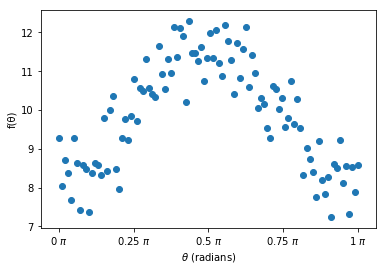

In [112]:
#θarr = np.random.uniform(0, np.pi, 15)
θarr = np.linspace(0, np.pi, 100)
farr = np.array([neuron.f(θ) for θ in θarr])
plt.scatter(θarr/np.pi, farr)
plt.xlabel("$θ$ (radians)")
plt.ylabel("f(θ)")
# Magic incantation for radians from http://stackoverflow.com/a/40642200
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.25))

In [116]:
np.savez("regression_orientation-tuning_data.npz", θarr=θarr, farr=farr)